In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import copy
import time

In [2]:
# Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Current path
#path = '/content/drive/MyDrive/Colab Notebooks/Work/Reactors/Pseudomonas Reactor/'
path = ''

## Import Bioreactors data

In [4]:
RSEED = 42
np.random.seed(RSEED)
torch.manual_seed(RSEED)

In [5]:
# Load bioreactor data
full_sheet = pd.ExcelFile(path + 'BioreactorPsdmData.xlsx')
df_adip7d  = pd.read_excel(full_sheet, 'bioreactors 7d')
df_lostbio7d  = pd.read_excel(full_sheet, 'lost biomass 7d')

# Group the dataframe by 'reactor'
reactor_dfs = {name: group.reset_index(drop=True) for name, group in df_adip7d.groupby('reactor')}

# Get list of reactor keys and shuffle
reactor_keys = list(reactor_dfs.keys())
random.shuffle(reactor_keys)

for key in reactor_keys:
    reactor_dfs[key] = reactor_dfs[key].sample(frac=1).reset_index(drop=True)

In [6]:
df_adip7d

,reactor,media,glucose,flow_rate_microL,flow_rate,cychl,time,adipic_acid,out_biomass,out_biomas_dg
0,Reactor_1,0.25,2,195,0.195,10,1,0.000000,28.872288,0.288723
1,Reactor_1,0.25,2,195,0.195,10,2,0.093127,35.369568,0.353696
2,Reactor_1,0.25,2,195,0.195,10,3,0.205484,24.178003,0.241780
3,Reactor_1,0.25,2,195,0.195,10,4,0.189075,28.612397,0.286124
4,Reactor_1,0.25,2,195,0.195,10,5,0.169618,28.295654,0.282957
...,...,...,...,...,...,...,...,...,...,...
123,Reactor_16,1.00,2,105,0.105,50,4,0.000000,0.974592,0.009746
124,Reactor_16,1.00,2,105,0.105,50,5,0.000000,1.827360,0.018274
125,Reactor_16,1.00,2,105,0.105,50,6,0.000000,1.595894,0.015959
126,Reactor_16,1.00,2,105,0.105,50,7,0.000000,1.815178,0.018152


## Classes and functions definitions

In [7]:
class ReactorNetwork(nn.Module):
    def __init__(self, n_inputs, n_hidden_1, n_hidden_2, n_outputs):
        super(ReactorNetwork, self).__init__()
        layers = []

        # Inputs
        layers.append(nn.Linear(n_inputs, n_hidden_1))
        layers.append(nn.Sigmoid())

        # Hidden layers
        layers.append(nn.Linear(n_hidden_1, n_hidden_2))
        layers.append(nn.Sigmoid())

        # Output
        layers.append(nn.Linear(n_hidden_2, n_outputs))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class ReactorDataset(Dataset):
  '''
  Creates a Dataset where each element corresponds to a different bioreactor time series
  '''
  def __init__(self, df, input_cols, output_cols, shuffle_within=True, convert_to_tensors = False):
    # Group data by reactor
    self.reactor_dfs = {name: group.reset_index(drop=True) for name, group in df.groupby('reactor')}

    # Store input/output column names
    self.input_cols = input_cols
    self.output_cols = output_cols
    self.shuffle_within = shuffle_within
    self.convert_to_tensors = convert_to_tensors

    # List of reactor names (shuffled)
    self.reactor_keys = list(self.reactor_dfs.keys())
    random.seed(RSEED)
    random.shuffle(self.reactor_keys)
    random.seed()

    # Shuffle each reator data if shuffle_within = True
    if self.shuffle_within:
      for key in self.reactor_keys:
        self.reactor_dfs[key] = self.reactor_dfs[key].sample(frac=1).reset_index(drop=True)

  def __len__(self):
    return len(self.reactor_keys)


  def __getitem__(self, idx):
    # Get reactor name by index
    reactor_name = self.reactor_keys[idx]
    df_reactor = self.reactor_dfs[reactor_name]

    # Get input/output as numpy arrays
    X = df_reactor[self.input_cols].values.astype(np.float32)
    y = df_reactor[self.output_cols].values.astype(np.float32)

    if self.convert_to_tensors:
      X = torch.tensor(X)
      y = torch.tensor(y)

    return X, y, reactor_name

def train_FFNN(dataloader, model, loss_fn, optimizer):
    model.train()
    losses_over_batches = []

    for X_batch, y_batch, reactor_name in dataloader:
        # X_batch, y_batch shapes: (1, 8, features)
        # Remove batch dimension (since it's 1)
        X_batch = X_batch.squeeze(0)
        y_batch = y_batch.squeeze(0)

        # Predict
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        losses_over_batches.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Compute average train loss
    avg_train_loss = np.mean(losses_over_batches)

    return avg_train_loss

def validate_FFNN(dataloader, model, loss_fn):
    model.eval()
    batch_val_loss = []

    with torch.no_grad():
      for X_val, y_val, _ in dataloader:
        # X_batch, y_batch shapes: (1, 8, features)
        # Remove batch dimension (since it's 1)
        X_val = X_val.squeeze(0)
        y_val = y_val.squeeze(0)
       
        # Predict
        y_pred = model(X_val)
        loss = loss_fn(y_pred, y_val)
        batch_val_loss.append(loss.item())

    # Compute average validation loss
    avg_val_loss = np.mean(batch_val_loss)

    return avg_val_loss

## Basic training

In [8]:
# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [9]:
# Crop strings
input_columns = ['media', 'glucose', 'flow_rate', 'cychl', 'time']
output_columns = ['adipic_acid', 'out_biomas_dg']

In [59]:
# Define training and validation datasets
dataset = ReactorDataset(df_adip7d, input_columns, output_columns, convert_to_tensors=True)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

num_reactors = len(dataset)

# Define split
val_ratio = 0.15
val_size = int(num_reactors * val_ratio)
train_size = num_reactors - val_size
print(f"Training with {train_size} reactors and validating with {val_size} reactors")

# Split dataset
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

Training with 14 reactors and validating with 2 reactors


In [60]:
# Setting hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
hidden_layers = 3
n_hidden_1 = 32
n_hidden_2 = 16
lr = 5e-4
epochs = 1500

# Build model
reactor_model = ReactorNetwork(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

# Train and validate
total_train_losses = []
total_val_losses   = []

for epoch in range(epochs):

  # Train the model
  avg_train_loss = train_FFNN(train_loader, reactor_model, loss_function, optimizer)

  # Validate the model
  avg_val_loss = validate_FFNN(val_loader, reactor_model, loss_function)

  # Save losses values
  total_train_losses.append(avg_train_loss)
  total_val_losses.append(avg_val_loss)

  if epoch % 500 == 0:
    print(f'Epoch {epoch+1}/{epochs}\nTrain Loss: {total_train_losses[-1]:.4f}, Val Loss: {total_val_losses[-1]:.4f}')
    print('-------------------------------------')

Epoch 1/1500
Train Loss: 0.6036, Val Loss: 0.1664
-------------------------------------
Epoch 501/1500
Train Loss: 0.1461, Val Loss: 0.2106
-------------------------------------
Epoch 1001/1500
Train Loss: 0.0963, Val Loss: 0.1584
-------------------------------------


Hidden layers: 3
Number of neurons in hidden layer 1: 32
Number of neurons in hidden layer 2: 16
Learning rate: 0.0005
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


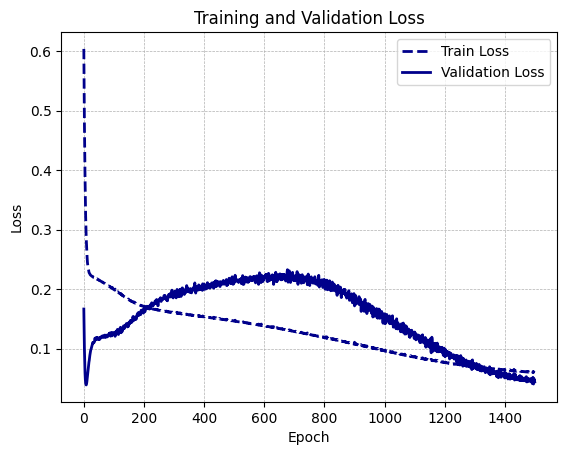

In [61]:
# Printing architectures details
print(f"Hidden layers: {hidden_layers}")
print(f"Number of neurons in hidden layer 1: {n_hidden_1}")
print(f"Number of neurons in hidden layer 2: {n_hidden_2}")
print(f"Learning rate: {lr}")
print(f"Optimizer: {optimizer}")

# Average score/error computed from the

plt.plot(total_train_losses, lw=2, c='darkblue', label='Train Loss', linestyle='--')
plt.plot(total_val_losses, lw=2, c='darkblue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Hyperparameter tunning

### Batch size

Here I will perform some level hyperparameter tunning, first i want to know if it is better to use a batch size of 1 or 2

In [ ]:
# Define training and validation datasets
dataset = ReactorDataset(df_adip7d, input_columns, output_columns, convert_to_tensors=True)
num_reactors = len(dataset)

# k-fold split
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)

# Split dataset
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [84]:
# Setting hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
k_folds = 8
hidden_layers = 2
n_hidden_1 = 32
n_hidden_2 = 16
lr = 5e-4
batch_sizes = [1,2]
epochs = 1500


result_batches_avg = []
result_batches_std = []

for batch_size in batch_sizes:
  # For saving final validation loss of each fold
  fold_results = []
  for fold, (train_idx, val_idx) in enumerate(kf.split(range(num_reactors))):
    print(f"----------- Fold {fold+1}/{k_folds} Batch size {batch_size} -----------")

    # Subset datasets
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset   = torch.utils.data.Subset(dataset, val_idx)

    # Dataloaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
      
    # Build model
    reactor_model = ReactorNetwork(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

    # Loss and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

    # Save best model and model performance
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):

      # Train the model
      avg_train_loss = train_FFNN(train_loader, reactor_model, loss_function, optimizer)

      # Validate the model
      avg_val_loss = validate_FFNN(val_loader, reactor_model, loss_function)

      if epoch % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
        print(f'Valid Loss: {avg_val_loss:.4f}\n')
    
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_model_state = copy.deepcopy(reactor_model.state_dict())

    # Save fold performance over validation set
    fold_results.append(avg_val_loss)

  # Compute full CV results
  kfold_avg_val_loss = np.mean(fold_results)
  kfold_std_val_loss = np.std(fold_results)

  # Save results for this batch
  result_batches_avg.append(kfold_avg_val_loss)
  result_batches_std.append(kfold_std_val_loss)

  print('Cross validation results (batch_size = {batch_size})')
  print(f"Average validation loss: {kfold_avg_val_loss:4f} ± {kfold_std_val_loss:4f}")

# Show results for batch sizes
print('\n-------------- Bach sizes results --------------')
for i in batch_sizes:
  print(f"Batch size: {i}")
  print(f"Average validation loss: {result_batches_avg[i-1]:4f} ± {result_batches_std[i-1]:4f}")

----------- Fold 1/8 Batch size 1 -----------
Epoch [1/1500]
Train Loss: 0.4302
Valid Loss: 0.5314

Epoch [501/1500]
Train Loss: 0.1430
Valid Loss: 0.1422

Epoch [1001/1500]
Train Loss: 0.0668
Valid Loss: 0.0964

----------- Fold 2/8 Batch size 1 -----------
Epoch [1/1500]
Train Loss: 0.6943
Valid Loss: 0.4312

Epoch [501/1500]
Train Loss: 0.1351
Valid Loss: 0.1344

Epoch [1001/1500]
Train Loss: 0.0573
Valid Loss: 0.0526

----------- Fold 3/8 Batch size 1 -----------
Epoch [1/1500]
Train Loss: 0.2778
Valid Loss: 0.3464

Epoch [501/1500]
Train Loss: 0.1076
Valid Loss: 0.2861

Epoch [1001/1500]
Train Loss: 0.0418
Valid Loss: 0.2517

----------- Fold 4/8 Batch size 1 -----------
Epoch [1/1500]
Train Loss: 0.7657
Valid Loss: 0.1204

Epoch [501/1500]
Train Loss: 0.1494
Valid Loss: 0.1941

Epoch [1001/1500]
Train Loss: 0.0770
Valid Loss: 0.0657

----------- Fold 5/8 Batch size 1 -----------
Epoch [1/1500]
Train Loss: 0.5227
Valid Loss: 0.1657

Epoch [501/1500]
Train Loss: 0.1176
Valid Loss: 

The tests show a lower average validation loss when using a batch size of 1. How ever, given the high standard deviation, I cannot say that the two obtained averages are distiguishable. For this reason, I choose that the batch size for now should be equal to 1.

### Hidden Neurons

In [ ]:
# Define training and validation datasets
dataset = ReactorDataset(df_adip7d, input_columns, output_columns, convert_to_tensors=True)
num_reactors = len(dataset)

# k-fold split
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)

# Split dataset
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [ ]:
n_inputs = len(input_columns)
n_outputs = len(output_columns)
k_folds = 8
hidden_layers = 2
hidden_units = [16, 32, 64]
lr = 5e-4
batch_size = 1
epochs = 1500

result_batches_avg = []
result_batches_std = []

# For the grid search heatmap
A_heatmap_avg = np.zeros((len(hidden_units), len(hidden_units)))
A_heatmap_std = np.zeros((len(hidden_units), len(hidden_units)))



for i in range(len(hidden_units)):
    for j in range(len(hidden_units)):
        # For saving final validation loss of each fold
        fold_results = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(range(num_reactors))):
            print(f"----------- Fold: {fold+1}/{k_folds} -----------")
            print(f"1st hidden layer: {hidden_units[i]} units")
            print(f"2nd hidden layer: {hidden_units[j]} units\n")

            # Subset datasets
            train_subset = torch.utils.data.Subset(dataset, train_idx)
            val_subset   = torch.utils.data.Subset(dataset, val_idx)

            # Dataloaders
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
            
            # Build model
            reactor_model = ReactorNetwork(n_inputs, hidden_units[i], hidden_units[j], n_outputs)

            # Loss and optimizer
            loss_function = nn.MSELoss()
            optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

            # Save best model and model performance
            #best_val_loss = float('inf')
            #best_model_state = None

            for epoch in range(epochs):

                # Train the model
                avg_train_loss = train_FFNN(train_loader, reactor_model, loss_function, optimizer)

                # Validate the model
                avg_val_loss = validate_FFNN(val_loader, reactor_model, loss_function)

                if epoch % 500 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
                    print(f'Valid Loss: {avg_val_loss:.4f}\n')
                
            #if avg_val_loss < best_val_loss:
                #best_val_loss = avg_val_loss
                #best_model_state = copy.deepcopy(reactor_model.state_dict())

            # Save fold performance over validation set
            fold_results.append(avg_val_loss)

        # Compute full CV results and save to the heatmap matrix
        A_heatmap_avg[i,j] = np.mean(fold_results)
        A_heatmap_std[i,j] = np.std(fold_results)

        print(f'Cross validation results (Hidden units = [{hidden_units[i],hidden_units[j]}])')
        print(f"Average validation loss: {np.mean(fold_results):4f} ± {np.std(fold_results):4f}")

----------- Fold: 1/8 -----------
1st hidden layer: 16 units
2nd hidden layer: 16 units

Epoch [1/1500]
Train Loss: 0.3612
Valid Loss: 0.4234

Epoch [501/1500]
Train Loss: 0.1600
Valid Loss: 0.1745

Epoch [1001/1500]
Train Loss: 0.0899
Valid Loss: 0.0749

----------- Fold: 2/8 -----------
1st hidden layer: 16 units
2nd hidden layer: 16 units

Epoch [1/1500]
Train Loss: 0.3536
Valid Loss: 0.2127

Epoch [501/1500]
Train Loss: 0.1556
Valid Loss: 0.1524

Epoch [1001/1500]
Train Loss: 0.0859
Valid Loss: 0.0919

----------- Fold: 3/8 -----------
1st hidden layer: 16 units
2nd hidden layer: 16 units

Epoch [1/1500]
Train Loss: 0.6127
Valid Loss: 0.7741

Epoch [501/1500]
Train Loss: 0.1285
Valid Loss: 0.2924

Epoch [1001/1500]
Train Loss: 0.0501
Valid Loss: 0.2756

----------- Fold: 4/8 -----------
1st hidden layer: 16 units
2nd hidden layer: 16 units

Epoch [1/1500]
Train Loss: 0.2361
Valid Loss: 0.0765

Epoch [501/1500]
Train Loss: 0.1505
Valid Loss: 0.1954

Epoch [1001/1500]
Train Loss: 0.0

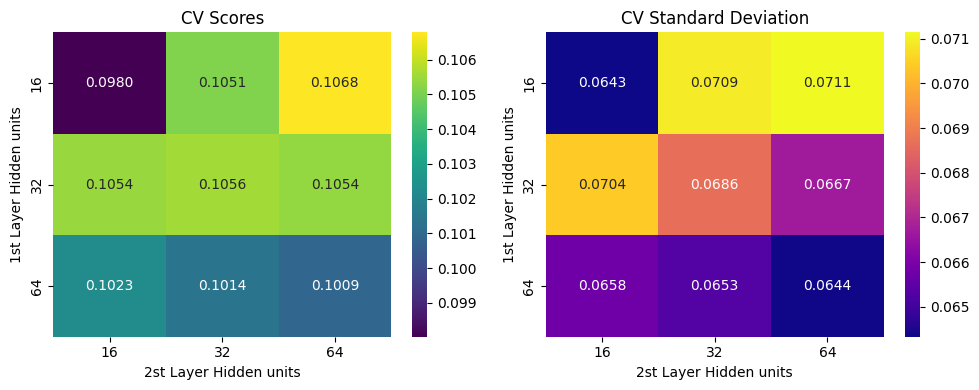

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Heatmap for CV score values
sns.heatmap(A_heatmap_avg, ax=axes[0], cmap='viridis', annot=True, fmt=".4f", xticklabels=hidden_units, yticklabels=hidden_units, cbar=True)
axes[0].set_title("CV Scores")
axes[0].set_xlabel("2st Layer Hidden units")
axes[0].set_ylabel("1st Layer Hidden units")

# Heatmap for CV scores standard deviation
sns.heatmap(A_heatmap_std, ax=axes[1], cmap='plasma', annot=True, fmt=".4f", xticklabels=hidden_units, yticklabels=hidden_units, cbar=True)
axes[1].set_title("CV Standard Deviation")
axes[1].set_xlabel("2st Layer Hidden units")
axes[1].set_ylabel("1st Layer Hidden units")

plt.tight_layout()
plt.show()

We observe no meaningful difference between the different arquitectures, hence, we decide to use the simplest type of network. We choose to use 16 hidden units in both 1st and 2nd hidden layer.

With this choice, the optimized value of the CV score is:

$$\mathbf{CV}_{score} = 0.0980 \pm 0.0643$$

## CV Score of the fine tunned model

In [14]:
reactor_labels = df_adip7d["reactor"].values
unique_reactor_labels = np.unique(reactor_labels) 

# Training of the fine tuned model
kf = KFold(n_splits=8, shuffle=True, random_state=RSEED)
fold_scores = []

# Setting hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
n_hidden_1 = 16
n_hidden_2 = 16
lr = 5e-4
epochs = 1500


for train_reactor_idx, val_reactor_idx in kf.split(unique_reactor_labels):
    print('Train-Valid reactor split:')
    print(train_reactor_idx)
    print(val_reactor_idx)

    # Randomly choose the reactors for training and validating
    train_reactors = unique_reactor_labels[train_reactor_idx]
    val_reactors   = unique_reactor_labels[val_reactor_idx]

    # Masks for spliting the reactors
    train_mask = np.isin(reactor_labels, train_reactors)
    val_mask   = np.isin(reactor_labels, val_reactors)

    # Split reactors into train-validation
    train_df = df_adip7d[train_mask]
    val_df = df_adip7d[val_mask]

    # DataSets
    train_subset = ReactorDataset(train_df, input_columns, output_columns, convert_to_tensors=True, shuffle_within=False)
    val_subset   = ReactorDataset(val_df, input_columns, output_columns, convert_to_tensors=True, shuffle_within=False)

    # Dataloaders
    train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=1, shuffle=False)

    # Build fine tuned model
    reactor_model = ReactorNetwork(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

    # Loss and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

    # Train model
    for epoch in range(epochs):
        # Train the model
        avg_train_loss = train_FFNN(train_loader, reactor_model, loss_function, optimizer)

        # Validate the model
        avg_val_loss = validate_FFNN(val_loader, reactor_model, loss_function)

        if epoch % 500 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
            print(f'Valid Loss: {avg_val_loss:.4f}\n')
    
    # Save score on current fold
    fold_scores.append(avg_val_loss)

print(f"Mean MSE: {np.mean(fold_scores)}")
print(f"MSE StanDev: {np.std(fold_scores)}")

Train-Valid reactor split:
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[0 1]
Epoch [1/1500]
Train Loss: 0.5591
Valid Loss: 0.5257

Epoch [501/1500]
Train Loss: 0.1659
Valid Loss: 0.1358

Epoch [1001/1500]
Train Loss: 0.0875
Valid Loss: 0.0595

Train-Valid reactor split:
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 15]
[ 5 14]
Epoch [1/1500]
Train Loss: 0.3742
Valid Loss: 0.1069

Epoch [501/1500]
Train Loss: 0.1514
Valid Loss: 0.1845

Epoch [1001/1500]
Train Loss: 0.0875
Valid Loss: 0.0763

Train-Valid reactor split:
[ 0  1  2  3  4  5  6  7  8  9 10 12 14 15]
[11 13]
Epoch [1/1500]
Train Loss: 0.7595
Valid Loss: 0.9979

Epoch [501/1500]
Train Loss: 0.1395
Valid Loss: 0.2377

Epoch [1001/1500]
Train Loss: 0.0791
Valid Loss: 0.0950

Train-Valid reactor split:
[ 0  1  2  3  4  5  6  7 10 11 12 13 14 15]
[8 9]
Epoch [1/1500]
Train Loss: 0.4508
Valid Loss: 0.6239

Epoch [501/1500]
Train Loss: 0.1578
Valid Loss: 0.2078

Epoch [1001/1500]
Train Loss: 0.0963
Valid Loss: 0.1409

Train-Valid reactor 

## Plot Adipic Acid prediction

Using the fine-tuned values of the hyperparameters, select a signle train-validation split and visualize the performanc eof adipic acid over time.

In [10]:
train_reactors, val_reactors = train_test_split(unique_reactor_labels, test_size=0.1, random_state=RSEED-1)

# Masks for spliting the reactors
train_mask = np.isin(reactor_labels, train_reactors)
val_mask   = np.isin(reactor_labels, val_reactors)

# Split reactors into train-validation
train_df = df_adip7d[train_mask]
val_df = df_adip7d[val_mask]

# DataSets
train_subset = ReactorDataset(train_df, input_columns, output_columns, convert_to_tensors=True, shuffle_within=False)
val_subset   = ReactorDataset(val_df, input_columns, output_columns, convert_to_tensors=True, shuffle_within=False)

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=1, shuffle=False)

# Setting hyperparameters
n_inputs = len(input_columns)
n_outputs = len(output_columns)
n_hidden_1 = 16
n_hidden_2 = 16
lr = 5e-4
epochs = 1500


# Build fine tuned model
reactor_model = ReactorNetwork(n_inputs, n_hidden_1, n_hidden_2, n_outputs)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(reactor_model.parameters(), lr=lr)

start_time = time.time()
for epoch in range(epochs):

    # Train the model
    avg_train_loss = train_FFNN(train_loader, reactor_model, loss_function, optimizer)

    # Validate the model
    avg_val_loss = validate_FFNN(val_loader, reactor_model, loss_function)

    if epoch % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}]\nTrain Loss: {avg_train_loss:.4f}')
        print(f'Valid Loss: {avg_val_loss:.4f}\n')
training_time = time.time() - start_time
print(f"Total training time: {training_time} seconds")

Epoch [1/1500]
Train Loss: 0.3501
Valid Loss: 0.6869

Epoch [501/1500]
Train Loss: 0.1413
Valid Loss: 0.3067

Epoch [1001/1500]
Train Loss: 0.0889
Valid Loss: 0.2214

Total training time: 15.452505826950073 seconds


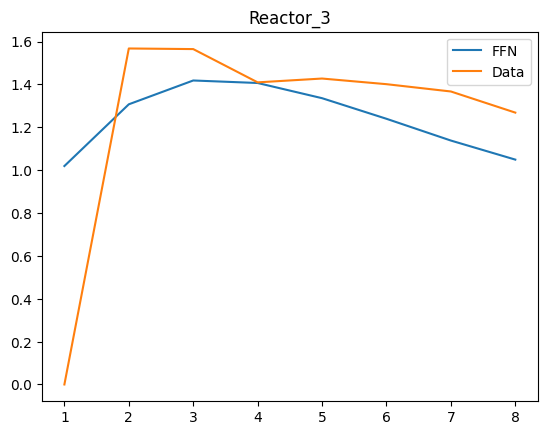

In [365]:
# Predict
i=1
y_pred = reactor_model(val_subset[i][0]).detach().cpu().numpy()
plt.plot(val_subset[i][0][:,4], y_pred[:,0], label = 'FFN')
plt.plot(val_subset[i][0][:,4], val_subset[i][1][:,0], label='Data')
plt.title(val_reactors[i])
plt.legend();

In [ ]:
# Save predicted data in a numpy array
np.save('AdipPred-FFN-Reactor_3.npy', y_pred[:,0])